# Building the pipeline for working with EEG data

In this notebook
- we build the codes to extract initial raw data;
- we calculate different metrics as measures of functional connectivity;
- based on calculated measures like Mutual Information and Coherence we create Adjacency Matrices; 
- we create graphs based on the previously calculated metrics;
- make some plots to visualize the obtained graphs.

MAYBE based on graphs we will train some graph convolutional neural networks...

# 0 - Required packages



In [14]:
import sys
from glob2 import glob

import numpy as np
import pandas as pd # dataframes, tables 
import seaborn as sns # plotting
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import networkx as nx

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

# 1 - Datasets Links

 Links for downloading the datasets: https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
 
 Command for getting the data from the server: 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_abnormal/v2.0.0/ . 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_epilepsy/v1.0.0/ .

TUH EEG Epilepsy Corpus. It was created to provide data for the purposes of automatic analysis of EEG. The patients were sorted by using a filter that categorized patients into two classes: epilepsy and not epilepsy. This was based on information in the session reports relating to their clinical history, medications at the time of recording, and EEG features associated with epilepsy. 
This subset contains European data format (EDF) files and corresponding neurologist reports for 1,648 files in  561 sessions from 200 patients. From these, 1473 files in 436 sessions from 100 patients have epilepsy, whereas 326 files in 134 sessions from 100 patients do not have epilepsy.
link: https://isip.piconepress.com/conferences/ieee_spmb/2017/papers/p01_13.pdf

FILENAME STRUCTURE "TUH EEG Epilepsy Corpus.":

 A typical filename in this corpus is: edf/epilepsy/01_tcp_ar/003/00000355/s003_2013_01_04/00000355_s003_t000.edf

 The first segment, "edf/", is a directory name for the directory containing the data, which consists of edf files (*.edf) and EEG reports (*.txt).

 The second segment denotes either patients with epilepsy ("/epilepsy") or patients with without epilepsy ("/no_epilepsy").

 The third segment ("/01_tcp_ar") denotes the type of channel configurationfor the EEG. "/01_tcp_ar" refers to an AR reference configuration.

 The fourth segment ("003") is a three-digit identifier meant to keep the number of subdirectories in a directory manageable. This follows the TUH EEG v1.1.0 convention.

 The fifth segment ("/00000355") denotes an anonymized patient ID. The IDs are consistent across all of our databases involving Temple
 Hospital EEG data.

 The sixth segment ("/s003_2013_01_04") denotes the session number("s003"), and the date the EEG was archived at the hospital("01/04/2013").

 The seventh, or last, segment is the filename ("00000355_s003_t000.edf"). This includes the patient number, the session number and a token number ("t000").

 Sessions were sorted into epilepsy and no epilepsy categories by searching the associated EEG reports for indications as to a epilepsy/no epilepsy 
 diagnosis based on clinical history, medications at the time of recording, and EEG features associated with epilepsy such as spike and sharp waves. 


## 1.1 - Loading data from .edf files

In [2]:
# reading the list of file names in the EEG Epilepsy Corpus
edf_file_list = glob("../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf")


#edf_file_list = glob("../tuh_eeg_abnormal/edf/*/*/*/*/*/*/*.edf")
len(edf_file_list)

1648

There are 1648 with data files in the TUH Epilepsy database.

In [18]:
# print out several filenames
edf_file_list[:4]

['../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t001.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t003.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t002.edf']

In [20]:
# extract subject IDs from the file path, create python set to extract unique elements from list, convert to list again 
unique_epilepsy_patient_ids = list(set([x.split("/")[-1].split("_")[0] for x in edf_file_list]))
len(unique_epilepsy_patient_ids)

200

There are 200 unique patients in the database.

In [21]:
# write down the list all the patient IDs into one file for later use
with open('../subject_lists/epilepsy_corpus_subjects.txt', 'w') as file_handler:
    for item in unique_epilepsy_patient_ids:
        file_handler.write("{}\n".format(item))

In [8]:
edf_file_list[0].split("/")

['..',
 'tuh_eeg_epilepsy',
 'edf',
 'epilepsy',
 '03_tcp_ar_a',
 '076',
 '00007656',
 's010_2011_03_13',
 '00007656_s010_t000.edf']

In [119]:
def read_edf_to_pandas(edf_filename):
    """ Reads data from an edf file to a Pandas dataframe.
        Column names are 'channel_labels'.
        
        Returns: dataframe, channel labels
    """
    # read edf file
    raw_data = read_raw_edf(edf_filename, verbose=False, preload=False)
    
    # get channel names
    channel_labels = raw_data.info["ch_names"]
    
    # create a dataframe from
    df = pd.DataFrame(raw_data.get_data(), index=channel_labels).T

    return df, channel_labels


In [182]:
raw_data_no_epilepsy = read_raw_edf('../tuh_eeg_epilepsy/edf/no_epilepsy/03_tcp_ar_a/076/00007671/s002_2011_02_03/00007671_s002_t002.edf',
                       verbose=0, preload=False)

raw_data_epilepsy = read_raw_edf('../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
                       verbose=0, preload=False)

In [183]:
edf_file_epilepsy = '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf'
edf_file_no_epilepsy = '../tuh_eeg_epilepsy/edf/no_epilepsy/03_tcp_ar_a/076/00007671/s002_2011_02_03/00007671_s002_t002.edf'

## 1.3 - Function for computing and plotting the Correlation Matrix

In [121]:
def compute_corr_matrix(edf_filename):
    
    # read edf file from filename
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
    
    return corr_matrix


def plot_correlation_matrix(edf_filename):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a correlation matrix.
    """
    # read edf file from filename
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
        
    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    sns.heatmap(corr_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Correlation Matrix')
    plt.xlabel('channel_name')
    plt.ylabel('channel_name')

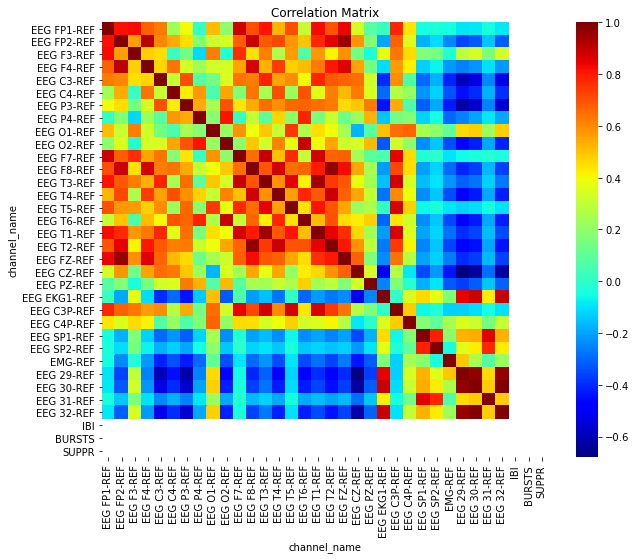

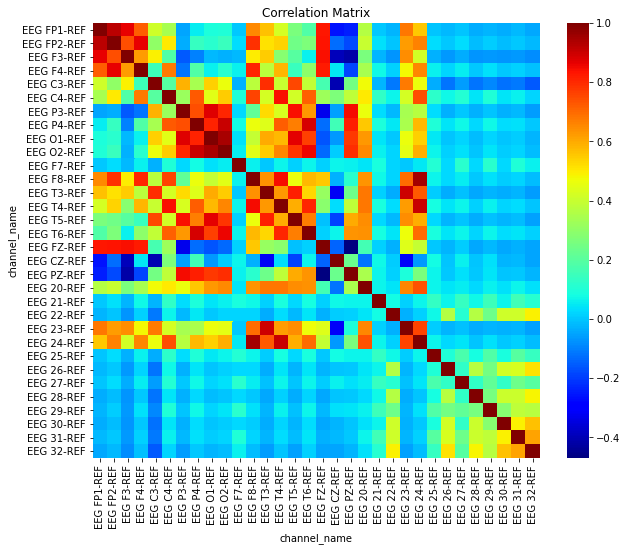

In [185]:
plot_correlation_matrix(edf_filename=edf_file_epilepsy)
plot_correlation_matrix(edf_filename=edf_file_no_epilepsy)

## 1.4 - Function for computing and plotting the Mutual Information Matrix

In [103]:
def entropy(bins, *X):
    
    # binning of the data
    data, *edges = np.histogramdd(X, bins=bins)
    
    # calculate probabilities
    data = data.astype(float)/data.sum()
    
    # compute H(X,Y,...,Z) = sum(-P(x,y,...,z) ∗ log2(P(x,y,...,z)))
    return np.sum(-data * np.log2(data+sys.float_info.epsilon))


def mutual_information(bins, X, Y):
    
    # compute I(X,Y) = H(X) + H(Y) − H(X,Y)
    
    H_X = entropy(bins, X)
    H_Y = entropy(bins, Y)
    H_XY = entropy(bins, X, Y)
    
    return H_X + H_Y - H_XY

def compute_mi_matrix(bins, df):
    
    n_cols = df.shape[1]
    mi_matrix = np.zeros([n_cols, n_cols])
    
    for i in range(n_cols):
        for j in range(n_cols):
            mi = mutual_information(bins, df.iloc[:,i],df.iloc[:,j])
            mi_matrix[i,j] = mi
            
    return mi_matrix

In [105]:
def plot_mutual_information_matrix(edf_filename, bins = 20):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a mutual information matrix.
    """
    # read edf file from filename
    df, channel_labels = read_edf_to_pandas(edf_filename)

    # calculate the mutual information matrix
    mi_matrix = compute_mi_matrix(bins, df)
        
    # plot the heatmap for mutual information matrix
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    sns.heatmap(mi_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Mutual Information Matrix')
    plt.xlabel('channel_name')
    plt.ylabel('channel_name')

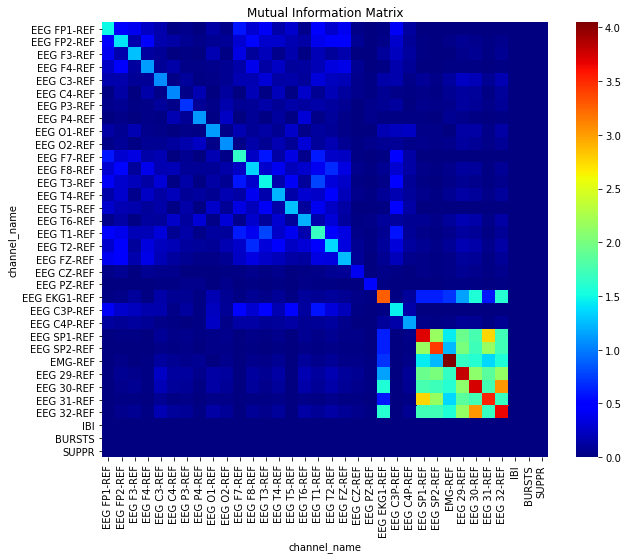

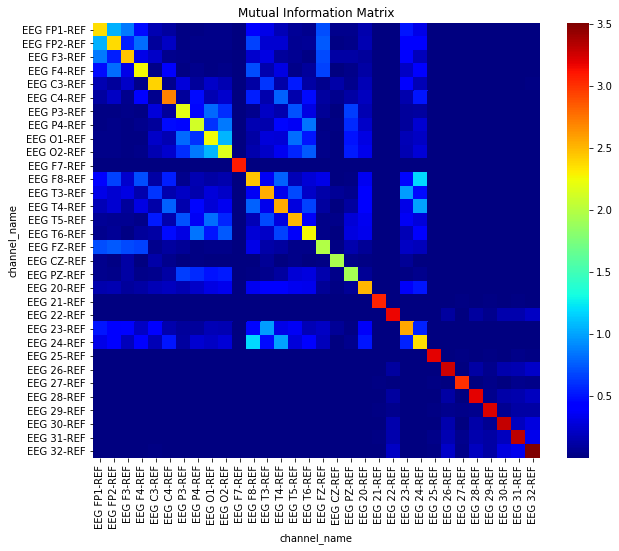

In [186]:
plot_mutual_information_matrix(edf_filename=edf_file_epilepsy, bins = 20)
plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)

## 1.5 - Hierarchical clustering and Dendrogram

In [163]:
def plot_dendogram(matrix, channel_labels):

    fig, ax = plt.subplots(1,1, figsize=(10,8))
    
    linkage_data = linkage(matrix,
                           metric = "euclidean",
                           method = "ward")
    
    dendrogram_plt = dendrogram(linkage_data,
                                labels = channel_labels,
                                ax = ax
                               )
    
    plt.title('Dendrogram')
    plt.xlabel('channels')
    plt.ylabel('Euclidean distances')
    plt.show()
    
    return dendrogram_plt, linkage_data

In [188]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
mi_matrix_epilepsy = compute_mi_matrix(bins=20, df=df)

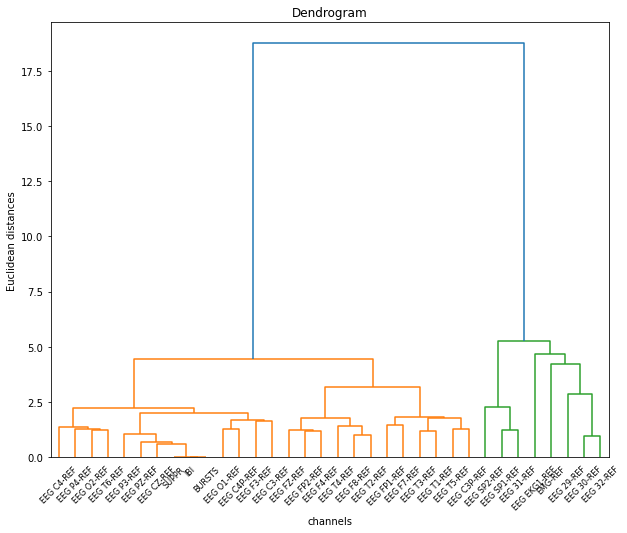

In [189]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_epilepsy, channel_labels)

In [190]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
mi_matrix_no_epilepsy = compute_mi_matrix(bins=20, df=df)

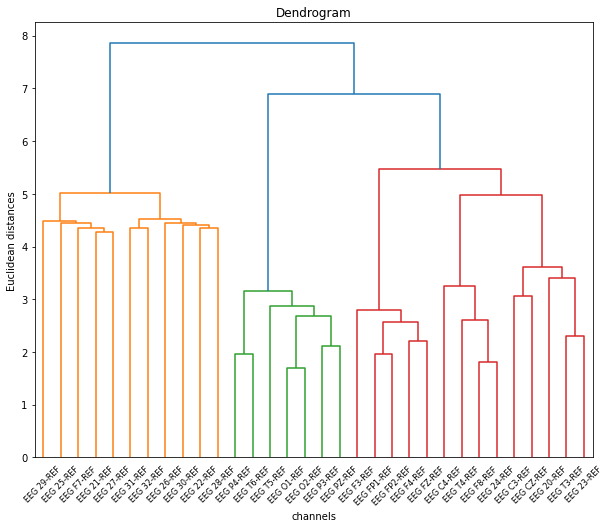

In [191]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_no_epilepsy, channel_labels)

## 1.6 - Graph representations based on computed matrices

![10-20 system](https://static-01.hindawi.com/articles/js/volume-2020/3083910/figures/3083910.fig.001.svgz)
<img src="https://www.vhv.rs/dpng/d/522-5220413_64-channel-eeg-cap-hd-png-download.png" alt="drawing" width="400"/>

In [150]:
# electrode positions for the graph nodes
# based on the pictures above

node_positions = {'EEG FP1-REF':(-1, 3),
                  'EEG FP2-REF':(1, 3),
                  'EEG F3-REF':(-1.5, 2),
                  'EEG FZ-REF':(0, 2),
                  'EEG F4-REF':(1.5, 2),
                  'EEG F7-REF':(-3, 2.2),
                  'EEG F8-REF':(3, 2.2),
                  'EEG C3-REF':(-2, 0),
                  'EEG C4-REF':(2, 0),
                  'EEG CZ-REF':(0, 0),
                  'EEG T3-REF':(-3.3, 0),
                  'EEG T4-REF':(3.3, 0),
                  'EEG P3-REF':(-1.5, -2), 
                  'EEG P4-REF':(1.5, -2),
                  'EEG PZ-REF':(0, -2),
                  'EEG T5-REF':(-3, -2.2),
                  'EEG T6-REF':(3, -2.2),
                  'EEG O1-REF':(-1, -3),
                  'EEG O2-REF':(1, -3),
                  'EEG C3P-REF':(-1.5, -1),
                  'EEG C4P-REF':(1.5, -1),
                  'EEG T1-REF':(0,0),
                  'EEG T2-REF':(0,0),
                  'EEG EKG1-REF':(0,0),
                  'EEG SP1-REF':(0,0),
                  'EEG SP2-REF':(0,0),
                  'EMG-REF':(0,0),
                  'EEG 29-REF':(0,0),
                  'EEG 30-REF':(0,0),
                  'EEG 31-REF':(0,0),
                  'EEG 32-REF':(0,0),
                  'IBI':(0,0),
                  'BURSTS':(0,0),
                  'SUPPR':(0,0)
                 }

In [159]:
# make a dataframe from a matrix 
# this will be our adjacency matrix

mi_df = pd.DataFrame(mi_matrix, 
                  columns=channel_labels)
mi_df.index = channel_labels

In [157]:
# represent the adjacency matrix as an edge list

edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['x', 'y', 'weight']

In [158]:
edge_list_df

,x,y,weight
0,EEG FP1-REF,EEG FP1-REF,1.493831e+00
1,EEG FP1-REF,EEG FP2-REF,4.486563e-01
2,EEG FP1-REF,EEG F3-REF,4.109979e-01
3,EEG FP1-REF,EEG F4-REF,2.394515e-01
4,EEG FP1-REF,EEG C3-REF,1.701052e-01
...,...,...,...
1151,SUPPR,EEG 31-REF,0.000000e+00
1152,SUPPR,EEG 32-REF,0.000000e+00
1153,SUPPR,IBI,3.203427e-16
1154,SUPPR,BURSTS,3.203427e-16


# 3 - Visualize EEG data

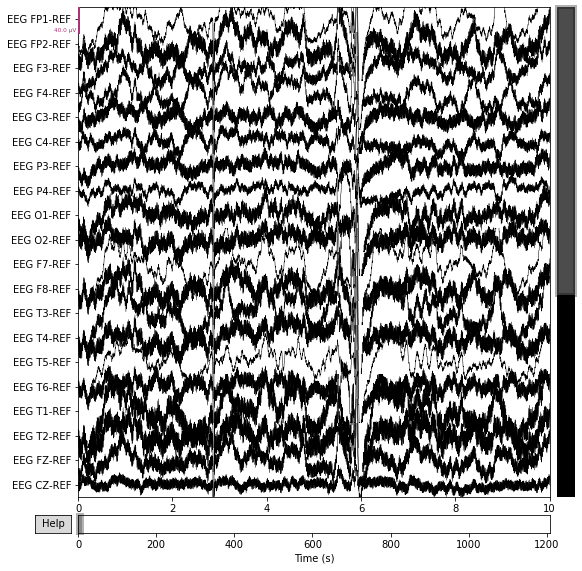

In [192]:
raw_data_epilepsy.plot()
plt.show()

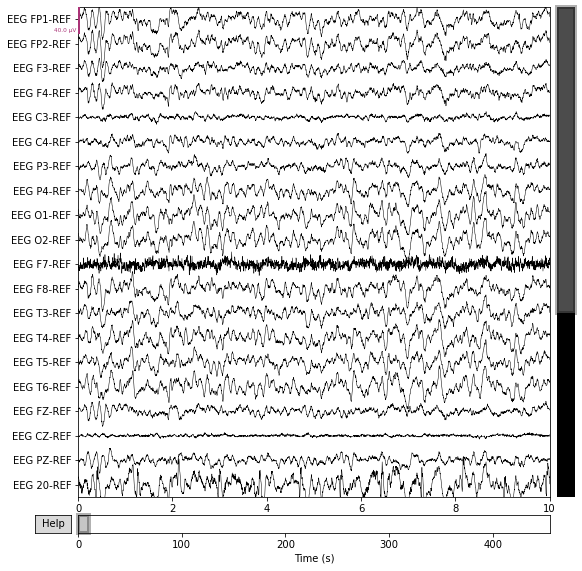

In [193]:
raw_data_no_epilepsy.plot()
plt.show()